In [1]:
from Data_retrieval import load_dataset
from NodeRank import GraphRanker
from Metrics.Coccurrences_class import Co_occurrencesGraph
from Metrics.Word2Vec_class import Word2VecGraph
from Utils import preprocess_text

from tqdm.notebook import tqdm
tqdm.pandas()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/geremiapompei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/geremiapompei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Phase 1: Retrieving relevant documents

In [2]:
df_texts, df_entities = load_dataset()

### df_texts

Contains pubmed documents represented in 2 columns:
- pmid: pubmed document id.
- text: text of the document (or only the abstract).

In [3]:
df_texts.head()

,pmid,text
0,37067723,CSF-based liquid biopsy pointing to a diagnosi...
1,37067721,Parkinson&#x27;s Disease and Diabetes Mellitus...
2,37067687,SIRT4 in ageing. Ageing is a phenomenon in whi...
3,37067567,In silico analysis of the possible crosstalk b...
4,37067031,Biological brain age prediction using machine ...


### df_entities
Contains pubmed documents entities represented in 8 columns:
- id: entity id.
- pmid: pubmed document id.
- mention: mention of entity inside the text.
- obj: tag assigned to the entity.
- prob: probability of tag assignment.
- span_begin: index of first character in the entity inside the document.
- span_end: index of the last character in the entity inside the document.

In [4]:
df_entities.head()

,id,pmid,mention,obj,prob,span_begin,span_end
0,mesh:D005910,37067723,diffuse glioma,disease,0.999984,51,65
1,NCBITaxon:9606,37067723,patient,species,0.974101,71,78
2,mesh:D001927,37067723,brain diseases,disease,0.999919,123,137
3,NCBITaxon:9606,37067723,patient,species,0.981700,271,278
4,NCBITaxon:9606,37067723,patient,species,0.938698,300,307


In [5]:
df_entities['obj'].value_counts()

obj
disease      95413
gene         57937
drug         32154
species      25136
cell_type    17075
DNA           9994
cell_line     5589
RNA           4058
mutation      1313
Name: count, dtype: int64

# Phase 2: Apply preprocessing

We delete rows in 'df_entities' if the probability is null or smaller than 0.8.

In [6]:
df_entities = df_entities[~df_entities['prob'].isna()]
df_entities = df_entities[df_entities['prob'] > 0.8]
df_entities = df_entities[['id', 'pmid', 'mention', 'obj', 'span_begin', 'span_end']]

df_entities.head()

,id,pmid,mention,obj,span_begin,span_end
0,mesh:D005910,37067723,diffuse glioma,disease,51,65
1,NCBITaxon:9606,37067723,patient,species,71,78
2,mesh:D001927,37067723,brain diseases,disease,123,137
3,NCBITaxon:9606,37067723,patient,species,271,278
4,NCBITaxon:9606,37067723,patient,species,300,307


In [7]:
df_entities.head()

,id,pmid,mention,obj,span_begin,span_end
0,mesh:D005910,37067723,diffuse glioma,disease,51,65
1,NCBITaxon:9606,37067723,patient,species,71,78
2,mesh:D001927,37067723,brain diseases,disease,123,137
3,NCBITaxon:9606,37067723,patient,species,271,278
4,NCBITaxon:9606,37067723,patient,species,300,307


In [8]:
occurrences_k_graph = Co_occurrencesGraph(df_entities)
occurrences_k_graph.populate_adj_matrix(k=20)

Co_occurrencesGraph populate_adj_matrix: 100%|██████████| 9898/9898 [00:43<00:00, 225.06it/s]


Max co-occurrences:  1108.0
Mean co-occurrences:  0.0009417776260310976
Std of co-occurrences:  0.21761708666603083


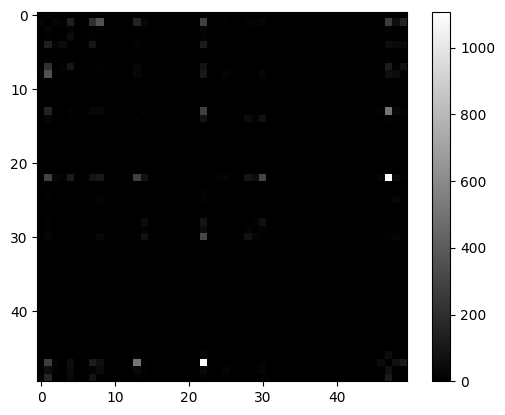

In [9]:
occurrences_k_graph.statistics()

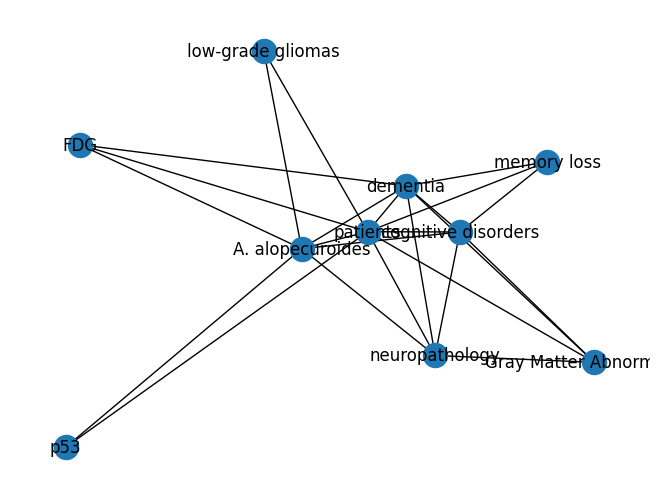

In [10]:
occurrences_k_graph.draw_example()

# Phase 4.1: Ranking

In [11]:
occur_graph_ranker = GraphRanker(occurrences_k_graph)

Top 10 Nodes

In [12]:
occur_graph_ranker.print_nodes_rank(max_=10)

SCORE	NAME (ID)
0.09%	neurodegenerative diseases (mesh:D019636)
0.08%	AD (mesh:D000544)
0.06%	Parkinson&#x27;s disease (mesh:C564486)
0.05%	patients (NCBITaxon:9606)
0.04%	PD (mim:168600)
0.03%	ALS (mesh:D000690)
0.02%	A. alopecuroides (CUI-less)
0.02%	dementia (mesh:D003704)
0.02%	solid tumors (mesh:D009369)
0.01%	cognitive disorders (mesh:D003072)


Top 10 Edges

In [13]:
occur_graph_ranker.print_edges_rank(max_=10)

SCORE	RELATION
1.46%	AD <=> neurodegenerative diseases
1.01%	PD <=> Parkinson&#x27;s disease
0.67%	AD <=> Parkinson&#x27;s disease
0.46%	A. alopecuroides <=> patients
0.4%	solid tumors <=> neurodegenerative diseases
0.38%	ALS <=> neurodegenerative diseases
0.37%	neurodegenerative diseases <=> patients
0.37%	neurodegenerative diseases <=> Parkinson&#x27;s disease
0.36%	PD <=> Parkinson&#
0.34%	AD <=> patients


# Variant: Word2Vec

In [14]:
id_to_wuid = {id: f'unique_{i}' for i, id in enumerate(df_entities['id'].unique())}
df_entities['wuid'] = df_entities['id'].apply(lambda x: id_to_wuid[x])

list(id_to_wuid.items())[:10]

[('mesh:D005910', 'unique_0'),
 ('NCBITaxon:9606', 'unique_1'),
 ('mesh:D001927', 'unique_2'),
 ('mesh:D000647', 'unique_3'),
 ('mesh:D003072', 'unique_4'),
 ('CHEBI:31617', 'unique_5'),
 ('mesh:D056784', 'unique_6'),
 ('mesh:D003704', 'unique_7'),
 ('CUI-less', 'unique_8'),
 ('NCBIGene:7157', 'unique_9')]

In [15]:
texts = df_texts.progress_apply(preprocess_text(df_entities,id_to_wuid), axis=1).tolist()

  0%|          | 0/9996 [00:00<?, ?it/s]

In [16]:
w2v_graph = Word2VecGraph(df_entities, texts)
w2v_graph.populate_adj_matrix(
    min_count=2,
    vector_size=100,
    window=10,
    sg=True,
    learning_rate=0.1,
    epochs=50,
)

Word2VecGraph populate_adj_matrix: 100%|██████████| 12674/12674 [04:11<00:00, 50.38it/s]


Max co-occurrences:  0.9823936820030212
Mean co-occurrences:  0.06481476644148512
Std of co-occurrences:  0.1026960760647625


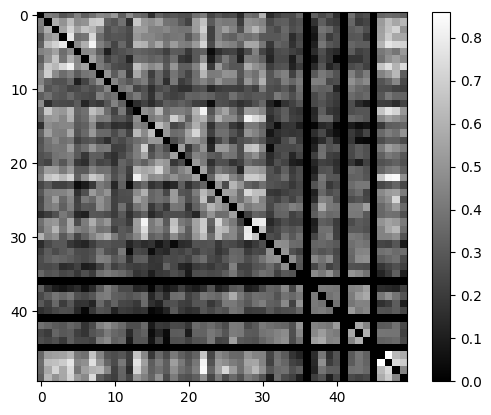

In [17]:
w2v_graph.statistics()

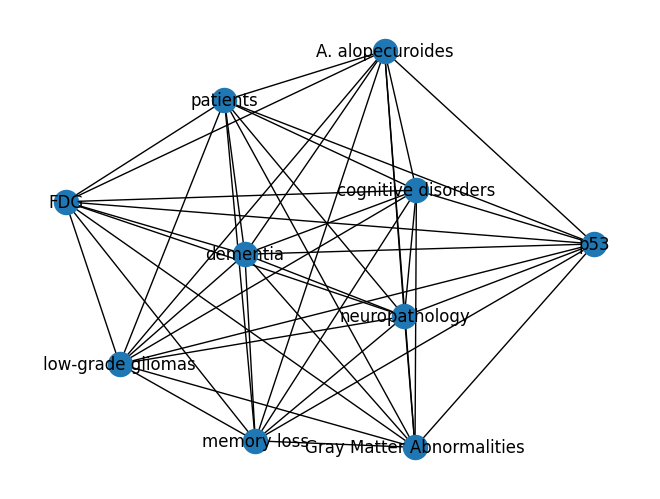

In [18]:
w2v_graph.draw_example()

In [19]:
w2v_graph_ranker = GraphRanker(w2v_graph)

Top nodes

In [20]:
w2v_graph_ranker.print_nodes_rank(max_=10)

SCORE	NAME (ID)
0.0%	neurodegenerative (mesh:D009410)
0.0%	A. alopecuroides (CUI-less)
0.0%	TrkB (NCBIGene:4915)
0.0%	TNF- (NCBIGene:7124)
0.0%	NOS (NCBIGene:4843)
0.0%	ERK (NCBIGene:5594)
0.0%	AKT (NCBIGene:207)
0.0%	Nrf2 (NCBIGene:4780)
0.0%	neuroinflammation (mesh:D020078)
0.0%	mouse (NCBITaxon:10090)


Top edges

In [21]:
w2v_graph_ranker.print_edges_rank(max_=10)

SCORE	RELATION
0.0%	DMKN <=> ROBO1
0.0%	IFI27L2 <=> DMKN
0.0%	CDC50 <=> ATP8A1
0.0%	ZNF571AS1 <=> A2MAS1
0.0%	pirfenidone <=> nintedanib
0.0%	CARB <=> LEV
0.0%	HSPA6 <=> TPBG
0.0%	Y1R <=> GALR2
0.0%	Asp12 <=> Asp130
0.0%	TVD-Ig <=> tetra-variable domain
